In [1]:
# Imports

import pandas as pd
from pathlib import Path
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Paths

processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "total_results"

ml_methods_path = processed_abstracts_path / "regex_scispacy/abstracts_with_ml_methods_regex.csv"
ml_category_path = processed_abstracts_path / "keywords/abstracts_with_labels.csv"
production_category_path = processed_abstracts_path / "umap_kmean_tuned/abstracts_with_clusters.csv"
prod_cluster_keywords_path = processed_abstracts_path / "umap_kmean_tuned/cluster_keywords.json"

# Ensure directories exist
for p in [processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [3]:
# Load Data

# ML-methods
df_ml_methods = pd.read_csv(ml_methods_path)

# ML-category
df_ml_category = pd.read_csv(ml_category_path)

# Production category
df_prod_category = pd.read_csv(production_category_path)

# Production cluster keywords
with open(prod_cluster_keywords_path, "r", encoding="utf-8") as f:
    prod_cluster_keywords = json.load(f)

In [4]:
# Check columns
print(df_ml_methods.columns)
print(df_ml_category.columns)
print(df_prod_category.columns)

Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'ml_methods_regex', 'method_count'],
      dtype='object')
Index(['query_id', 'doi', 'clean_abs', 'is_supervised', 'is_unsupervised',
       'is_reinforcement'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs', 'umap_x',
       'umap_y', 'kmeans_cluster'],
      dtype='object')


In [5]:
# Check head of each dataset
df_ml_methods.head(2)

,query_id,eid,doi,title,abstract,clean_abs,ml_methods_regex,method_count
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,[],0
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",[],0


In [6]:
df_ml_category.head(2)

,query_id,doi,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,ml_end_of_life,10.1016/B978-0-443-33740-6.00012-8,All rights reserved.As the production and cons...,False,False,False
1,ml_end_of_life,10.1080/19397038.2025.2563271,"Published by Informa UK Limited, trading as Ta...",False,False,False


In [7]:
df_prod_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,umap_x,umap_y,kmeans_cluster
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,5.887230,2.385923,3
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",5.282488,4.524463,11


In [8]:
df_ml_category.info()
print()
df_ml_methods.info()
print()
df_prod_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   query_id          33130 non-null  object
 1   doi               33129 non-null  object
 2   clean_abs         33129 non-null  object
 3   is_supervised     33130 non-null  bool  
 4   is_unsupervised   33130 non-null  bool  
 5   is_reinforcement  33130 non-null  bool  
dtypes: bool(3), object(3)
memory usage: 873.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   query_id          33130 non-null  object
 1   eid               33130 non-null  object
 2   doi               33129 non-null  object
 3   title             33130 non-null  object
 4   abstract          33130 non-null  object
 5   clean_abs         33129 non-null  obj

In [9]:
# Config

ID_COL = "doi"
RAW_ML_METHOD_COL = "ml_methods_regex"
ML_METHOD_COL = "ml_method"
ML_CAT_COL = "ml_category"
RAW_PROD_CAT_COL = "kmeans_cluster"
PROD_CAT_COL = "prod_category"



In [10]:
# Build ML categories per axis

ml_pred_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

ml_long = (
    df_ml_category[[ID_COL] + ml_pred_cols]
    .melt(id_vars=ID_COL, var_name="ml_axis", value_name="is_active")
)

ml_long = ml_long[ml_long["is_active"] == 1].copy()

ml_long[ML_CAT_COL] = ml_long["ml_axis"].map({
    "is_supervised": "supervised",
    "is_unsupervised": "unsupervised",
    "is_reinforcement": "reinforcement",
})

ml_long = ml_long[[ID_COL, ML_CAT_COL]]

ml_long[ML_CAT_COL].value_counts()


ml_category
supervised       11798
unsupervised      3754
reinforcement     1762
Name: count, dtype: int64

In [11]:
# Parse ML method list column

def parse_method_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x).strip()
    if not s or s == "[]":
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except (ValueError, SyntaxError):
        return [s]

df_ml_methods["ml_methods_list"] = df_ml_methods[RAW_ML_METHOD_COL].apply(parse_method_list)
df_ml_methods[[RAW_ML_METHOD_COL, "ml_methods_list"]].head(5)


,ml_methods_regex,ml_methods_list
0,[],[]
1,[],[]
2,['Reinforcement Learning'],[Reinforcement Learning]
3,['Differential Evolution'],[Differential Evolution]
4,[],[]


In [12]:
# Explode methods to one row per doi–method

df_methods_long = (
    df_ml_methods[[ID_COL, "ml_methods_list"]]
    .explode("ml_methods_list")
    .rename(columns={"ml_methods_list": ML_METHOD_COL})
)

df_methods_long = df_methods_long[
    df_methods_long[ML_METHOD_COL].notna()
    & (df_methods_long[ML_METHOD_COL].astype(str).str.strip() != "")
]

df_methods_long.head()


,doi,ml_method
2,10.1109/TEMSCON-ASPAC62480.2024.11025082,Reinforcement Learning
3,10.1188/23.CJON.595-601,Differential Evolution
5,10.3390/asi6050076,Linear Regression
6,10.1016/j.resconrec.2023.107073,Linear Regression
6,10.1016/j.resconrec.2023.107073,Support Vector Regression


In [13]:
# Production categories

df_prod_long = (
    df_prod_category[[ID_COL, RAW_PROD_CAT_COL]]
    .rename(columns={RAW_PROD_CAT_COL: PROD_CAT_COL})
)

df_prod_long.head()


,doi,prod_category
0,10.1016/B978-0-443-33740-6.00012-8,3
1,10.1080/19397038.2025.2563271,11
2,10.1109/TEMSCON-ASPAC62480.2024.11025082,10
3,10.1188/23.CJON.595-601,3
4,10.1039/d3va00106g,1


In [14]:
# Full long table: one row per doi–method–ml_category–prod_category

df_all = (
    df_methods_long[[ID_COL, ML_METHOD_COL]]
    .merge(ml_long, on=ID_COL, how="inner")
    .merge(df_prod_long, on=ID_COL, how="inner")
)

print(df_all.shape)
df_all.head()


(30212, 4)


,doi,ml_method,ml_category,prod_category
0,10.1109/TEMSCON-ASPAC62480.2024.11025082,Reinforcement Learning,unsupervised,10
1,10.1109/TEMSCON-ASPAC62480.2024.11025082,Reinforcement Learning,reinforcement,10
2,10.3390/asi6050076,Linear Regression,supervised,10
3,10.1016/j.resconrec.2023.107073,Linear Regression,supervised,10
4,10.1016/j.resconrec.2023.107073,Support Vector Regression,supervised,10


In [15]:
# Quick sanity check and neural network count

print("ML categories:")
print(df_all[ML_CAT_COL].value_counts())

print("\nProduction categories:")
print(df_all[PROD_CAT_COL].value_counts())

print("\nExample methods:")
print(df_all[ML_METHOD_COL].value_counts().head(20))


ML categories:
ml_category
supervised       22349
unsupervised      5232
reinforcement     2631
Name: count, dtype: int64

Production categories:
prod_category
0     5496
12    3125
6     2958
10    2522
1     2485
2     2228
7     1910
11    1875
3     1742
8     1648
5     1549
9     1477
4     1197
Name: count, dtype: int64

Example methods:
ml_method
Neural Network                  4135
Random Forest                   3365
Support Vector Machine          2462
Decision Tree                   1564
Gradient Boosting               1274
Reinforcement Learning          1264
XGBoost                         1205
Linear Regression                988
Principal Component Analysis     957
K-Nearest Neighbors              945
Convolutional Neural Network     912
Support Vector Regression        764
LSTM                             719
Autoencoder                      619
Logistic Regression              547
K-Means                          541
Bayesian Method                  539
Genetic Algori

In [16]:
# Counts per (ML category, production category, method)

group_cols = [ML_CAT_COL, PROD_CAT_COL, ML_METHOD_COL]

method_counts = (
    df_all
    .groupby(group_cols)[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
)

method_counts.head()


,ml_category,prod_category,ml_method,n_articles
0,reinforcement,0,Actor-Critic,1
1,reinforcement,0,Autoencoder,2
2,reinforcement,0,Bayesian Method,3
3,reinforcement,0,Convolutional Neural Network,7
4,reinforcement,0,Decision Tree,4


In [17]:
# Total unique articles per (ML category, production category)

cell_totals = (
    df_all
    .groupby([ML_CAT_COL, PROD_CAT_COL])[ID_COL]
    .nunique()
    .reset_index(name="cell_total")
)

cell_totals.head()


,ml_category,prod_category,cell_total
0,reinforcement,0,71
1,reinforcement,1,60
2,reinforcement,2,30
3,reinforcement,3,84
4,reinforcement,4,19


In [18]:
# Order categories by frequency of unique articles

ml_cat_order = (
    df_all
    .groupby(ML_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

prod_cat_order = (
    df_all
    .groupby(PROD_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

ml_cat_order, prod_cat_order


(['supervised', 'unsupervised', 'reinforcement'],
 [0, 12, 6, 1, 10, 2, 11, 8, 3, 7, 5, 9, 4])

In [19]:
# Top-k methods per cell

TOP_K = 3

method_counts["rank_in_cell"] = (
    method_counts
    .groupby([ML_CAT_COL, PROD_CAT_COL])["n_articles"]
    .rank(method="dense", ascending=False)
)

top_methods = (
    method_counts[method_counts["rank_in_cell"] <= TOP_K]
    .merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL], how="left")
    .sort_values([ML_CAT_COL, PROD_CAT_COL, "n_articles"], ascending=[True, True, False])
)

top_methods.head(10)


,ml_category,prod_category,ml_method,n_articles,rank_in_cell,cell_total
2,reinforcement,0,Reinforcement Learning,52,1.0,71
1,reinforcement,0,Neural Network,12,2.0,71
0,reinforcement,0,Deep Reinforcement Learning,10,3.0,71
5,reinforcement,1,Reinforcement Learning,37,1.0,60
4,reinforcement,1,Neural Network,17,2.0,60
3,reinforcement,1,Deep Reinforcement Learning,8,3.0,60
10,reinforcement,2,Reinforcement Learning,20,1.0,30
9,reinforcement,2,Neural Network,10,2.0,30
6,reinforcement,2,Bayesian Method,3,3.0,30
7,reinforcement,2,Convolutional Neural Network,3,3.0,30


In [20]:
# Build 2D map summary

def summarize_cell(group):
    total = int(group["cell_total"].iloc[0])
    methods_str = ", ".join(
        f"{m} ({int(n)})"
        for m, n in zip(group[ML_METHOD_COL], group["n_articles"])
    )
    return pd.Series({"summary": f"n={total}; top: {methods_str}"})

cell_summary = (
    top_methods
    .groupby([ML_CAT_COL, PROD_CAT_COL])
    .apply(summarize_cell)
    .reset_index()
)

cell_summary.head()


/tmp/ipykernel_2619022/602492248.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_cell)


,ml_category,prod_category,summary
0,reinforcement,0,"n=71; top: Reinforcement Learning (52), Neural..."
1,reinforcement,1,"n=60; top: Reinforcement Learning (37), Neural..."
2,reinforcement,2,"n=30; top: Reinforcement Learning (20), Neural..."
3,reinforcement,3,"n=84; top: Reinforcement Learning (58), Neural..."
4,reinforcement,4,"n=19; top: Reinforcement Learning (10), Neural..."


In [21]:
# Pivot to 2D grid

summary_grid = cell_summary.pivot(
    index=ML_CAT_COL,
    columns=PROD_CAT_COL,
    values="summary"
)

summary_grid = summary_grid.reindex(index=ml_cat_order, columns=prod_cat_order)

summary_grid


prod_category,0,12,6,1,10,2,11,8,3,7,5,9,4
ml_category,,,,,,,,,,,,,
supervised,"n=1479; top: Random Forest (500), Neural Netwo...","n=1063; top: Neural Network (451), Random Fore...","n=892; top: Random Forest (413), Neural Networ...","n=801; top: Random Forest (294), Neural Networ...","n=715; top: Random Forest (281), Neural Networ...","n=781; top: Neural Network (289), Random Fores...","n=372; top: Neural Network (112), Random Fores...","n=592; top: Neural Network (275), Support Vect...","n=536; top: Random Forest (161), Support Vecto...","n=559; top: Random Forest (217), Neural Networ...","n=472; top: Neural Network (177), Random Fores...","n=378; top: Neural Network (134), Random Fores...","n=391; top: Random Forest (124), Neural Networ..."
unsupervised,"n=682; top: Neural Network (180), Autoencoder ...","n=208; top: Neural Network (71), Principal Com...","n=172; top: Principal Component Analysis (60),...","n=112; top: Principal Component Analysis (49),...","n=113; top: K-Means (35), Neural Network (32),...","n=183; top: Neural Network (56), Principal Com...","n=96; top: Neural Network (25), Reinforcement ...","n=161; top: Neural Network (51), Principal Com...","n=167; top: Neural Network (40), K-Means (36),...","n=155; top: Principal Component Analysis (42),...","n=95; top: Neural Network (34), Principal Comp...","n=202; top: Neural Network (66), Support Vecto...","n=48; top: Neural Network (13), Autoencoder (1..."
reinforcement,"n=71; top: Reinforcement Learning (52), Neural...","n=54; top: Reinforcement Learning (46), Neural...","n=73; top: Random Forest (23), Reinforcement L...","n=60; top: Reinforcement Learning (37), Neural...","n=170; top: Reinforcement Learning (110), Neur...","n=30; top: Reinforcement Learning (20), Neural...","n=463; top: Reinforcement Learning (398), Deep...","n=28; top: Reinforcement Learning (25), Neural...","n=84; top: Reinforcement Learning (58), Neural...","n=36; top: Reinforcement Learning (22), Neural...","n=114; top: Reinforcement Learning (100), Neur...","n=97; top: Reinforcement Learning (77), Deep R...","n=19; top: Reinforcement Learning (10), Neural..."


In [62]:
# Short labels for production clusters based on first 3 keywords

def make_cluster_label(cid):
    cid_str = str(cid)
    if cid_str in prod_cluster_keywords:
        words = prod_cluster_keywords[cid_str][:4]
        return f"{cid} - " + ", ".join(words)
    return str(cid)

prod_cluster_label_map = {
    c: make_cluster_label(c)
    for c in df_all[PROD_CAT_COL].unique()
}

prod_cluster_label_map


{10: '10 - energy, forecasting, power, wind',
 0: '0 - maintenance, predictive maintenance, predictive, fault',
 3: '3 - product, design, business, research',
 11: '11 - manufacturing, industry, production, digital',
 4: '4 - battery, concrete, batteries, rul',
 12: '12 - process, manufacturing, additive, additive manufacturing',
 2: '2 - process, quality, machining, manufacturing',
 1: '1 - process, production, hydrogen, optimization',
 8: '8 - defect, welding, process, semiconductor',
 6: '6 - food, crop, agricultural, agriculture',
 5: '5 - process, design, control, optimization',
 9: '9 - iot, security, attacks, detection',
 7: '7 - oil, reservoir, production, wells'}

In [95]:
bubble_df = cell_summary.merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL])

bubble_df["prod_cluster_label"] = bubble_df[PROD_CAT_COL].map(prod_cluster_label_map)

fig = px.scatter(
    bubble_df,
    x="prod_cluster_label",
    y=ML_CAT_COL,
    size="cell_total",
    # text="summary",
    size_max=60
)

fig.update_traces(textposition="top center")
fig.update_layout(
    width=1800,  
    height=600   
)
fig.show()


In [84]:
# Label map from cluster id to short description
def make_cluster_label(cid):
    cid_str = str(cid)
    words = prod_cluster_keywords.get(cid_str, [])[:4]
    if words:
        return f"{cid} | " + ", ".join(words)
    return str(cid)

prod_label_map = {cid: make_cluster_label(cid) for cid in prod_cat_order}
prod_label_to_id = {v: k for k, v in prod_label_map.items()}

# Numeric grid for heatmap
numeric_grid = (
    cell_totals
    .pivot(index=ML_CAT_COL, columns=PROD_CAT_COL, values="cell_total")
    .reindex(index=ml_cat_order, columns=prod_cat_order)
)


In [ ]:
# Widgets

ml_cat_dropdown = widgets.Dropdown(
    options=ml_cat_order,
    description="ML cat",
    layout=widgets.Layout(width="300px")
)

prod_dropdown = widgets.Dropdown(
    options=[prod_label_map[c] for c in prod_cat_order],
    description="Prod",
    layout=widgets.Layout(width="400px")
)


In [86]:
# Callback for dashboard

def update_dashboard(ml_cat, prod_label, top_k=15):
    prod_id = prod_label_to_id[prod_label]
    
    subset = (
        method_counts
        .query(f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id")
        .sort_values("n_articles", ascending=False)
    )
    
    if subset.empty:
        print(f"No articles for cell: {ml_cat} × {prod_label}")
        return
    
    cell_n = int(
        cell_totals.query(
            f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id"
        )["cell_total"].iloc[0]
    )
    
    print(f"Cell: {ml_cat} × {prod_label}")
    print(f"Unique articles in cell: {cell_n}")
    print("\nTop methods:")
    
    display(subset[[ML_METHOD_COL, "n_articles"]].head(top_k))
    
    top_plot = subset.head(top_k)
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_plot[ML_METHOD_COL].astype(str), top_plot["n_articles"])
    plt.gca().invert_yaxis()
    plt.xlabel("Number of articles")
    plt.title("Top methods in selected cell")
    plt.tight_layout()
    plt.show()


In [87]:
# Bind widgets to callback

ui = widgets.VBox([ml_cat_dropdown, prod_dropdown])

out = widgets.interactive_output(
    update_dashboard,
    {"ml_cat": ml_cat_dropdown, "prod_label": prod_dropdown}
)

display(ui, out)


Output()

In [88]:
# ML category flags per article
ml_flag_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

df_ml_flags = df_ml_category[[ID_COL] + ml_flag_cols].copy()

# Count active categories
df_ml_flags["n_active"] = df_ml_flags[ml_flag_cols].sum(axis=1)

# Remove "none" (articles with zero ML categories)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] > 0].copy()

# Multi-label flags
df_ml_flags["is_multi"] = df_ml_flags["n_active"] > 1
df_ml_flags["multi_type"] = df_ml_flags["n_active"].map({
    1: "single",
    2: "double",
    3: "triple"
})

df_ml_flags["multi_type"].value_counts()


multi_type
single    12840
double     2093
triple       96
Name: count, dtype: int64

In [89]:
# Join ML flags with production cluster
ml_prod_flags = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

# Compute share per cluster
share_multi_by_prod = (
    ml_prod_flags
    .groupby(PROD_CAT_COL)["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

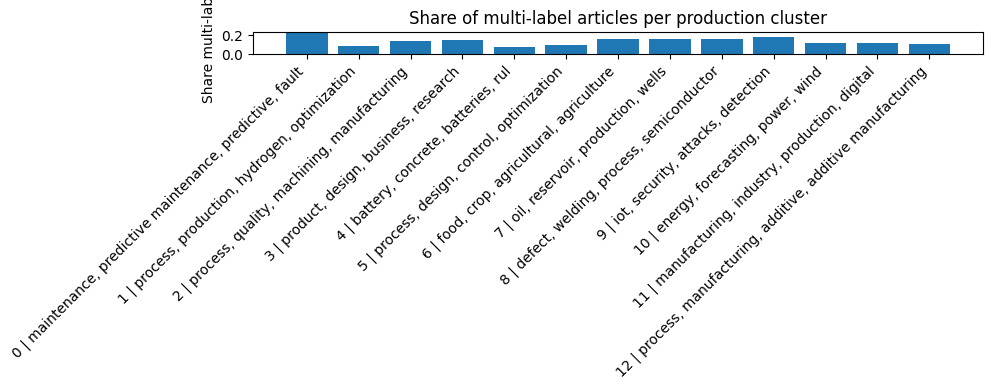

In [90]:
plot_df = share_multi_by_prod.copy()
plot_df["prod_label"] = plot_df[PROD_CAT_COL].map(prod_label_map)

plt.figure(figsize=(10, 4))
plt.bar(plot_df["prod_label"], plot_df["share_multi"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Share multi-label")
plt.title("Share of multi-label articles per production cluster")
plt.tight_layout()
plt.show()


In [91]:
ml_axis_long = df_ml_flags.melt(
    id_vars=[ID_COL, "is_multi"],
    value_vars=ml_flag_cols,
    var_name="ml_axis",
    value_name="is_active"
)

ml_axis_long = ml_axis_long[ml_axis_long["is_active"] == 1].copy()

ml_axis_long["ml_axis"] = ml_axis_long["ml_axis"].map({
    "is_supervised": "supervised",
    "is_unsupervised": "unsupervised",
    "is_reinforcement": "reinforcement"
})

share_multi_by_axis = (
    ml_axis_long
    .groupby("ml_axis")["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

share_multi_by_axis


,ml_axis,share_multi
0,reinforcement,0.271283
1,supervised,0.178674
2,unsupervised,0.502930


In [92]:
# Keep only multi-label (>=2)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] >= 2].copy()

def make_combo(row):
    parts = []
    if row["is_supervised"] == 1:
        parts.append("supervised")
    if row["is_unsupervised"] == 1:
        parts.append("unsupervised")
    if row["is_reinforcement"] == 1:
        parts.append("reinforcement")
    return "+".join(parts)

df_ml_flags["ml_combo"] = df_ml_flags.apply(make_combo, axis=1)


df_combo_prod = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

combo_by_prod = (
    df_combo_prod
    .groupby([PROD_CAT_COL, "ml_combo"])[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
    .sort_values(["prod_category", "n_articles"], ascending=[True, False])
)

top3_combo_prod = (
    combo_by_prod
    .sort_values("n_articles", ascending=False)
    .head(3)
)

top3_combo_prod



,prod_category,ml_combo,n_articles
1,0,supervised+unsupervised,499
9,2,supervised+unsupervised,158
31,8,supervised+unsupervised,144
